## Demographics and reported UFO sightings in 2016

R code for the analysis supporting my analysis of mass reports of UFO sightings from the [National UFO Reporting Center (NUFORC)](http://www.nuforc.org/webreports.html). Supporting files are in this GitHub repository. Code for data preparation and cleaning done prior to this are in the .R file, 'datacleaning.R'

In [3]:
library('plyr')
library('dplyr')
library('tidyr')
library('stringr')
library('ggplot2')
library('scales')
library('choroplethr')
library('choroplethrMaps')
library('gridExtra')

ufo.2016 <- readRDS('data/ufo_2016.RDS') # 2016 UFO sightings dataset, from datacleaning.R 

## Maps of UFO sightings in 2016

This code makes a bubble map of 2016 UFO sightings in the continguous U.S., with the bubbles sized according to sightings per 100 people in the county

Warning message:
“Removed 49 rows containing missing values (geom_point).”Warning message:
“Removed 49 rows containing missing values (geom_point).”

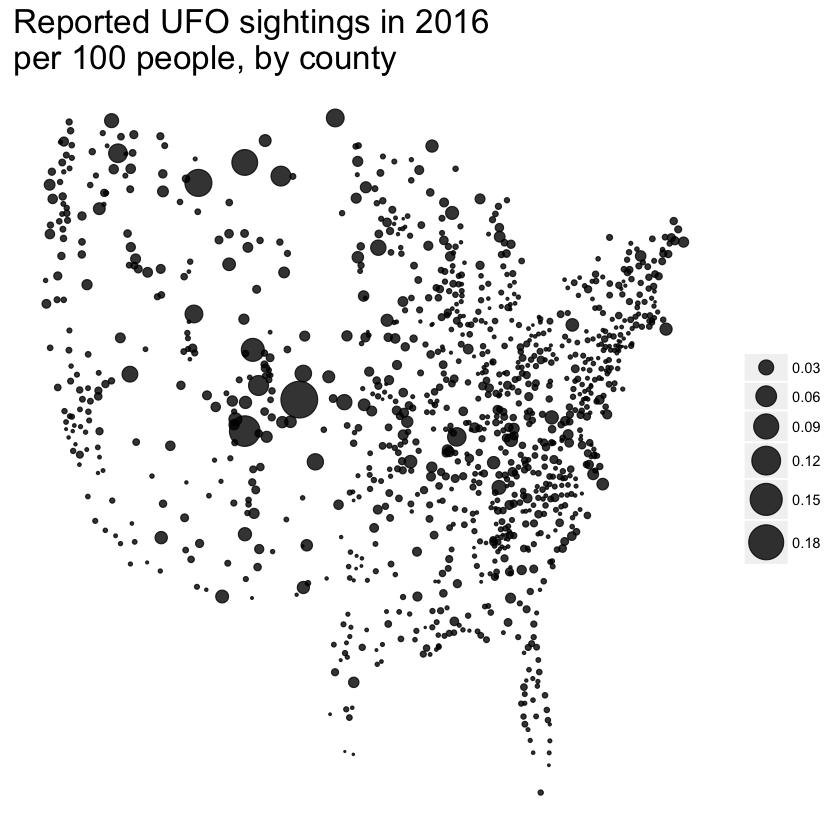

In [15]:
# make a map
ufo.counties <- ufo.2016 %>% 
  group_by(countyname, county.pop, state, fips) %>%
  summarise(lat = mean(lat), lng = mean(lng), n = n()) %>%
  mutate(percap = n/county.pop * 100) %>%
  ungroup() %>%
  arrange(desc(percap)) 

map.2016 <- ggplot(ufo.counties %>% filter(state != 'AK' & state != 'HI')) +
  geom_point(aes(lng, lat, size = percap), alpha = .8)+
  scale_size_area(breaks = seq(0, .2, .03), max_size = 10) +
  ggtitle('Reported UFO sightings in 2016\nper 100 people, by county') +
  theme(plot.title=element_text(size=20),axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks=element_blank(),axis.title.x=element_blank(),axis.title.y=element_blank(),panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),panel.grid.minor=element_blank(),plot.background=element_blank(), legend.title= element_blank())

plot(map.2016)

ggsave('plots/map2016.png', map.2016, width = 8, height = 6)

This code makes a choropleth map of 2016 UFO sightings in the continguous U.S., with the areas shaded according to sightings per 100 people in the county

region,countyname,county.pop,state,fips,lat,lng,n,percap,county.fips.character,county.name,state.name,state.fips.character,state.abb
1001,NA,NA,NA,NA,NA,NA,NA,NA,01001,autauga,alabama,01,AL
1003,Baldwin,195121,AL,1003,30.56898,-87.83429,3,0.001537507,01003,baldwin,alabama,01,AL
1005,NA,NA,NA,NA,NA,NA,NA,NA,01005,barbour,alabama,01,AL
1007,NA,NA,NA,NA,NA,NA,NA,NA,01007,bibb,alabama,01,AL
1009,NA,NA,NA,NA,NA,NA,NA,NA,01009,blount,alabama,01,AL
1011,NA,NA,NA,NA,NA,NA,NA,NA,01011,bullock,alabama,01,AL


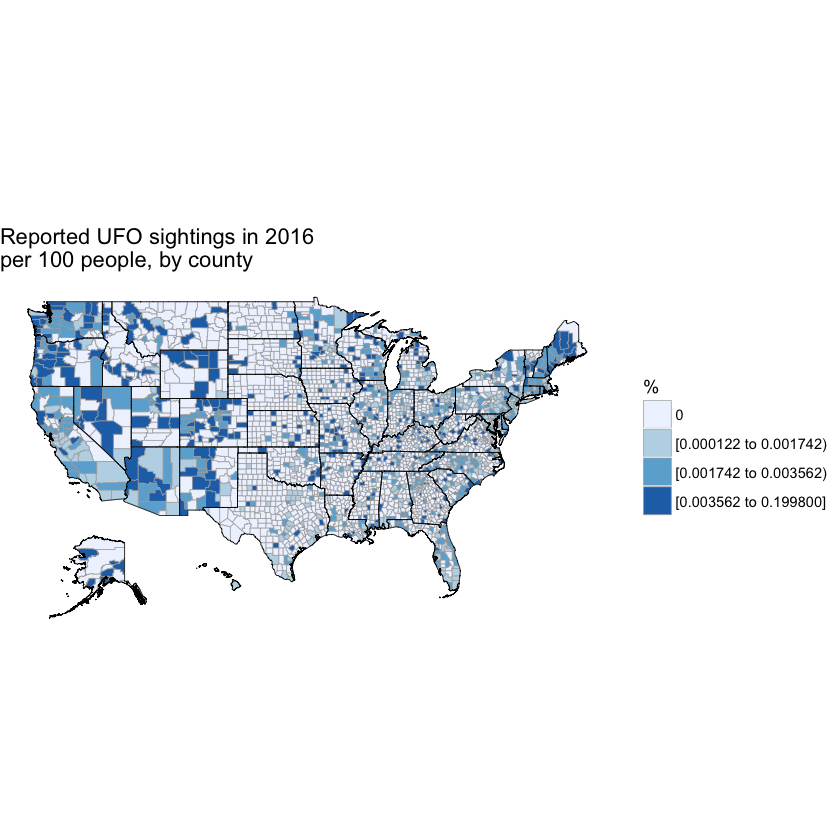

In [25]:
# Read county.regions dataframe supplied by choroplethrMaps package
data("county.regions")

# Create region column in ufo.counties dataframe (fips code) and join to county.regions dataframe
ufo.counties.map <- ufo.counties %>% filter(is.na(ufo.counties$fips) == F)

ufo.counties.map$region <- ufo.counties.map$fips

df <- merge(ufo.counties.map, county.regions, by= c('region'), all = T)
head(df)
df$value <- df$percap
df$value <- ifelse(is.na(df$percap) == T, 0,df$percap)   # Set the desired 'value' column for choroplethr

p <- county_choropleth(df, legend = "%", 
                  num_colors = 8, 
                  title = 'Reported UFO sightings in 2016\nper 100 people, by county')

plot(p)
ggsave('plots/choropleth.png', p, width=8, height=6)

## Is distance to a major airport a factor in UFO sightings?

This code creates a dataframe, `city.level`, of 2016 UFO sightings according to latitude and longitude. The `dist.aiport` variable is the distance (in meters) to the nearest major airport (defined as large or medium hubs from the [Federal Aviation Administration](https://www.faa.gov/airports/planning_capacity/npias/reports/). Plotting the number of reported sightings against distance to the nearest airport does not reveal any discernible correlation between the two variables.

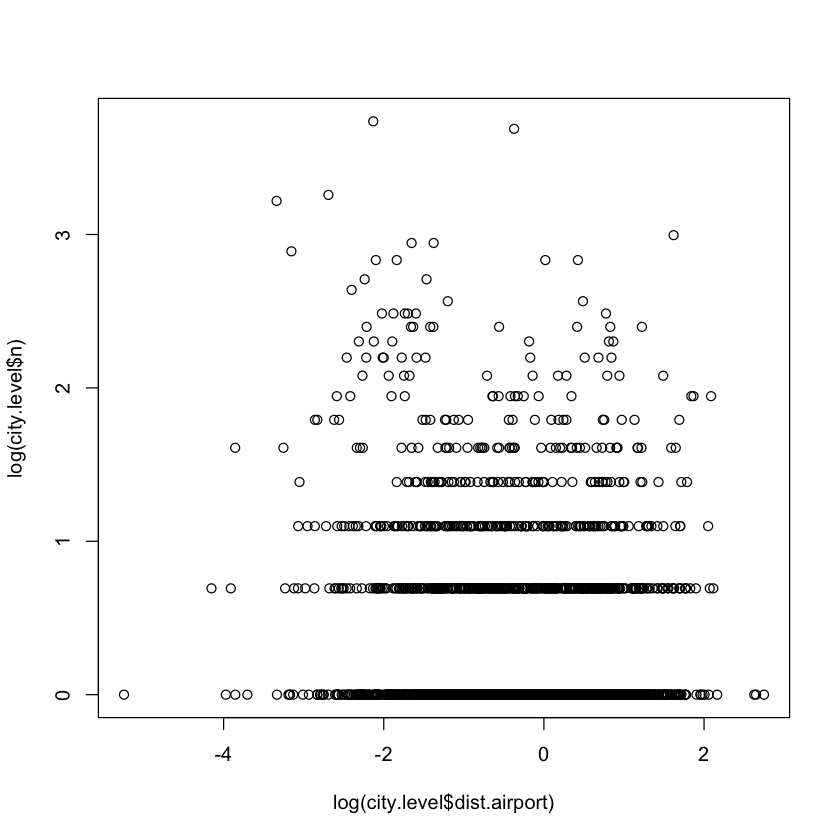

In [27]:
city.level <- ufo.2016 %>% group_by(lat, lng, city.new, state, dist.airport) %>%
  summarise(n = n())
  
plot(log(city.level$dist.airport), log(city.level$n)) # no discernible correlation

## Reported 2016 UFO sightings and county-level demographics

The demographics data are on the county-level, gathered from the [2015 American Community Survey](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml). The county-level election results are from [The Guardian and Townhall](https://github.com/tonmcg/County_Level_Election_Results_12-16). This code creates a county-level dataframe, `county.level.reg`, in order to explore correlations of per capita reported UFO sightings, `percap`, with demographic and electoral factors

In [29]:
county.level <- ufo.2016 %>% group_by(fips) %>%
  mutate(n = n()) %>%
  select(-city, -city.new, -countyname, -county_name, -lat, -lng, -id, -match, -event.date, -event.time, -event.month, -event.day, -event.year, -shape, -duration, -summary, -posted, -posted.date, -posted.year, -posted.month, -posted.day, -event.dow, -hoax, -has.note, -notes, -city.merge, -city, -grep("state", names(ufo.2016)), -airport, -airport.size,-airport.lat, -airport.lng, -dist.airport, -airport.id, -airport.city) %>%
  ungroup()

county.level.reg <- unique(county.level)
county.level.reg$percap <- county.level.reg$n/county.level.reg$county.pop * 100

Below is a correlation matrix of bi-variate correlations between county level per capita, `percap`, and the other vaiables in the dataset

In [30]:
m <- as.data.frame(cor(county.level.reg[, 7:47], use="pairwise.complete.obs"))
(m[41, ])

,county.hhinc,votes_dem_2016,votes_gop_2016,total_votes_2016,per_dem_2016,per_gop_2016,diff_2016,per_point_diff_2016,total_votes_2012,votes_dem_2012,⋯,county.area_uc,county.areapct_uc,county.popden_uc,county.pop_rural,county.poppct_rural,county.area_rural,county.areapct_rural,county.popden_rural,n,percap
percap,-0.1091065,-0.1222406,-0.1641774,-0.1423186,-0.2038307,0.1842076,-0.09792262,-0.1948826,-0.1518303,-0.1321552,⋯,-0.1186228,-0.04252716,0.004457293,-0.2443691,0.3635677,0.1055223,0.1830525,-0.2449879,-0.05511015,1


Some of the variables need log transformations, notably `percap`, to adjust for skew:

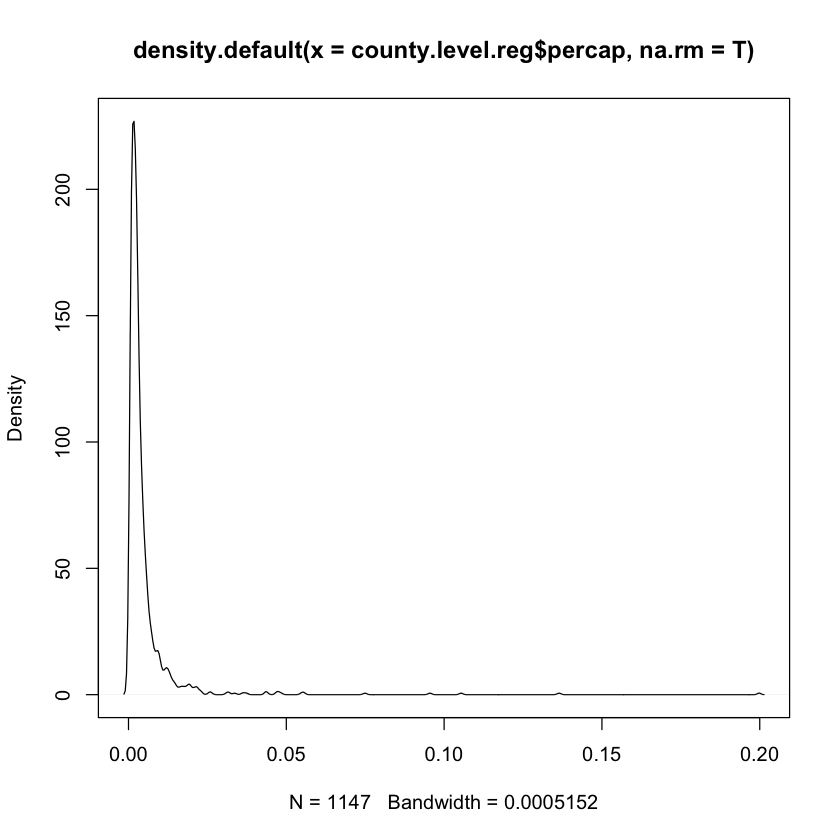

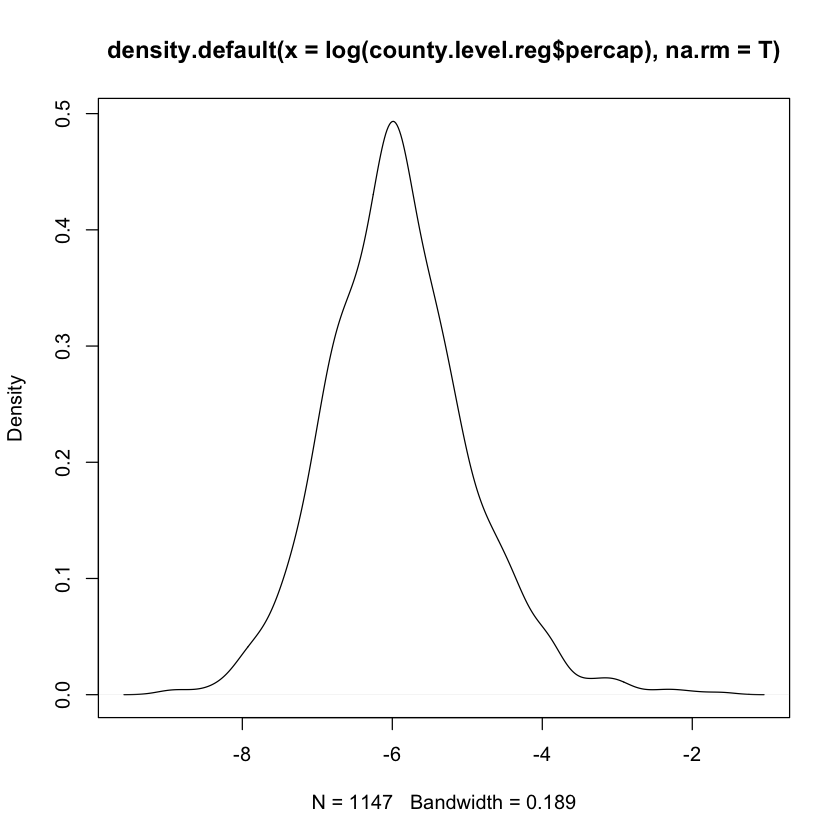

In [37]:
plot(density(county.level.reg$percap, na.rm = T))
plot(density(log(county.level.reg$percap), na.rm = T))

A simple scatterplot of counties’ vote percentage for Trump on their (logged) UFO reports per capita implies a positive correlation

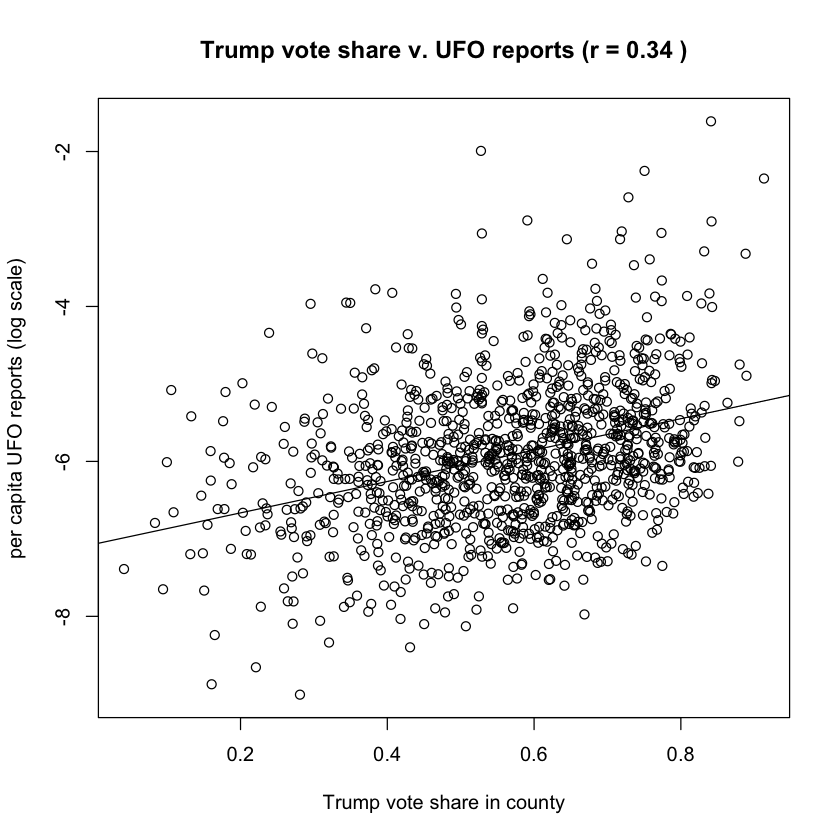

In [54]:
correlation <- cor(county.level.reg$per_gop_2016, log(county.level.reg$percap),
    use="pairwise.complete.obs")  

plot(county.level.reg$per_gop_2016, log(county.level.reg$percap), 
     xlab = 'Trump vote share in county',
     ylab = 'per capita UFO reports (log scale)' ,
  main = paste('Trump vote share v. UFO reports', '(r =' , round(correlation, 2), ')'))

abline(lm(log(county.level.reg$percap) ~ county.level.reg$per_gop_2016))

However, so does a scatterplot of rural population percentage (`county.poppct_rural`) and UFO reports.

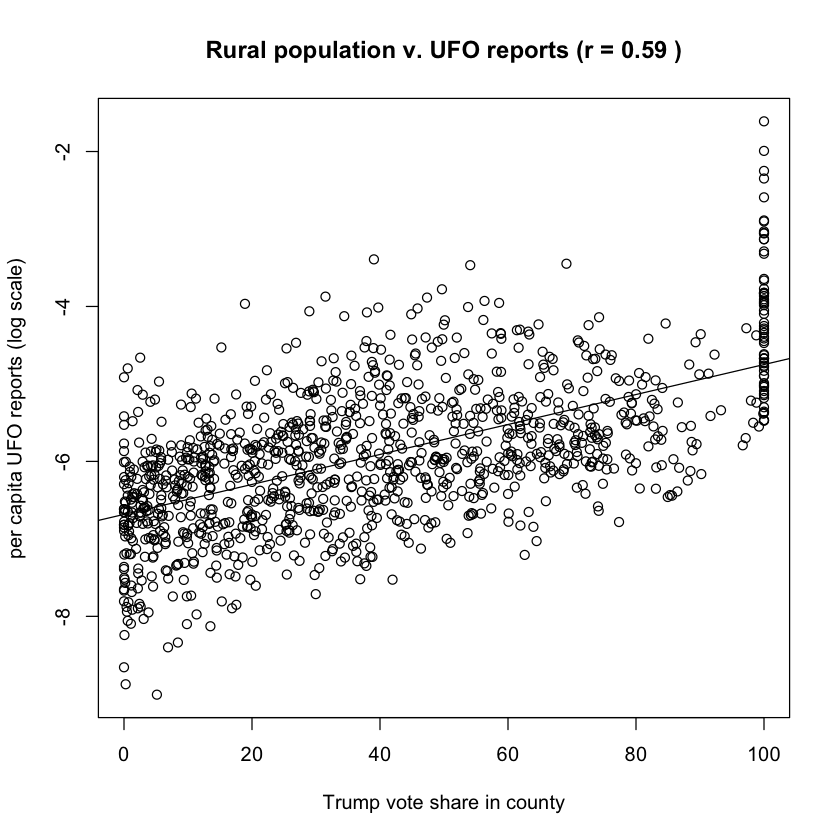

In [55]:
correlation <- cor(county.level.reg$county.poppct_rural, log(county.level.reg$percap),
    use="pairwise.complete.obs")  

plot(county.level.reg$county.poppct_rural, log(county.level.reg$percap), 
     xlab = 'Trump vote share in county',
     ylab = 'per capita UFO reports (log scale)' ,
  main = paste('Rural population v. UFO reports', '(r =' , round(correlation, 2), ')'))

abline(lm(log(county.level.reg$percap) ~ county.level.reg$county.poppct_rural))

## Regression model

This code runs a county-level regression with `log(percap)` (per capita UFO sightings) as the outcome and `log(county.hhinc)` (household median income in 2015), `per_gop_2016` (Trump vote share in 2016), and `division` (area of country)

In [56]:
fit <- lm(log(percap) ~ log(county.hhinc) + 
     per_gop_2016 + 
     county.poppct_rural +
       division,
   data = county.level.reg)

summary(fit)


Call:
lm(formula = log(percap) ~ log(county.hhinc) + per_gop_2016 + 
    county.poppct_rural + division, data = county.level.reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.07100 -0.45989 -0.01164  0.46227  2.41365 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -4.9284336  1.0503318  -4.692 3.03e-06 ***
log(county.hhinc)          -0.1992301  0.0954609  -2.087  0.03711 *  
per_gop_2016                0.5441951  0.1691989   3.216  0.00134 ** 
county.poppct_rural         0.0172668  0.0009278  18.611  < 2e-16 ***
divisionWest North Central  0.3952318  0.0804185   4.915 1.02e-06 ***
divisionMid-Atlantic       -0.1963403  0.0871274  -2.253  0.02442 *  
divisionNew England         0.3206518  0.1119679   2.864  0.00426 ** 
divisionEast South Central -0.1438204  0.0865601  -1.662  0.09689 .  
divisionSouth Atlantic      0.0395973  0.0676969   0.585  0.55872    
divisionWest South Central -0.1698444  0.0879162  

The coefficient on median household income is negative and percent vote for Trump is positive, indicating the correlation holds true even accounting for income and geography.

### Household income and sightings

The coefficient on `county.hhinc` is small but negative, indicating that poorer counties are more likely to have more UFO reports per capita. The distribution of UFO reports by household income can be further examined statistically. 

This code calculates and plots a probability density function for the total amount of reported UFO sightings for each income level. This shows, for example, that 80% of reported sightings come from households with median income of below 60,000.

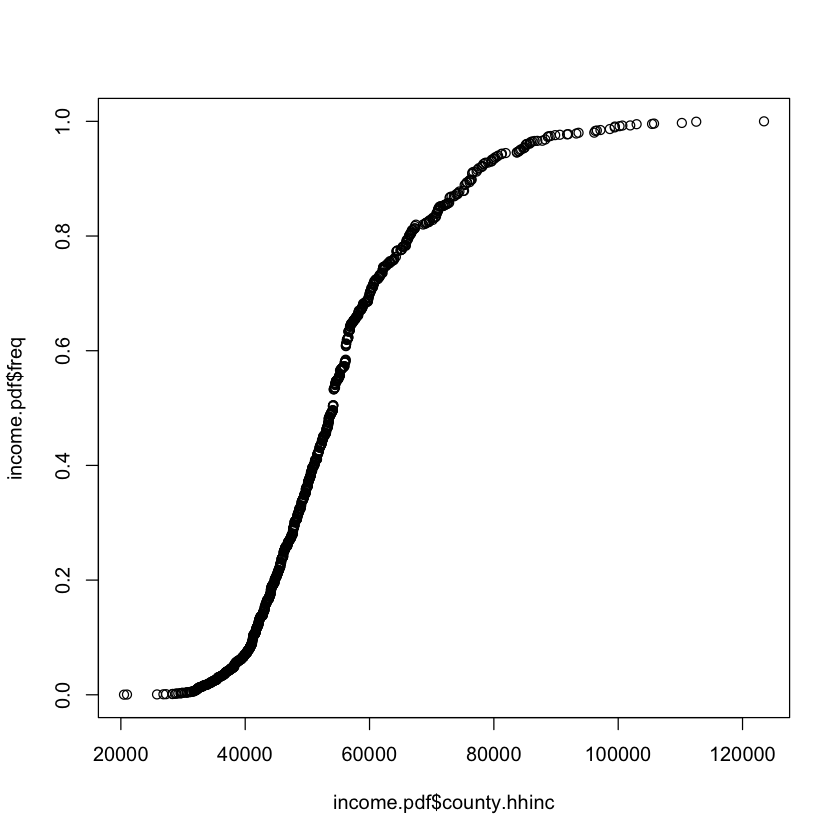

In [70]:
income.pdf <- county.level.reg %>% 
  group_by(county.hhinc) %>%
  summarise(n = sum(n))

income.pdf <- income.pdf %>% filter(is.na(county.hhinc) == F) %>%
  arrange(county.hhinc) %>% 
  mutate(cum.amount = cumsum(n), 
         total.number = sum(n), 
         freq = cum.amount/total.number)

plot(income.pdf$county.hhinc, income.pdf$freq)

This is only meaningful if it's very different from the U.S. as a whole. This code does the same thing, but for the United States.

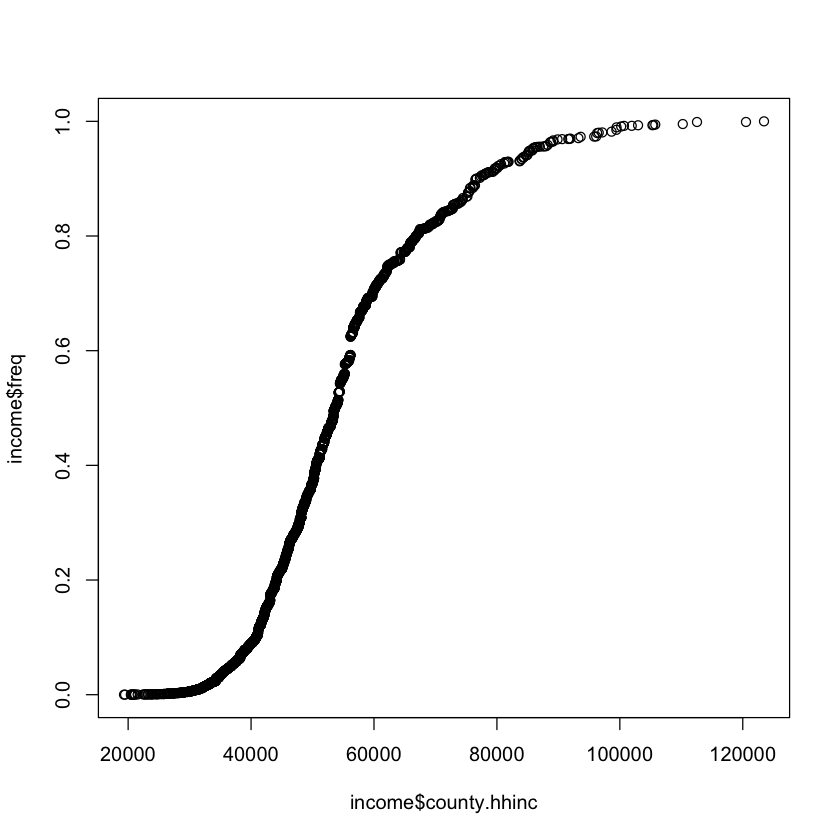

In [71]:
county.income <- readRDS('data/countyincome.RDS')
county.pop <- readRDS('data/countypop.RDS')

income <- merge(county.income, county.pop, by.x = 'geo.id2', by.y = 'GEO.id2')

income <- income %>%
  arrange(county.hhinc) %>% 
  mutate(cum.amount = cumsum(county.pop), 
         total.number = sum(county.pop), 
         freq = cum.amount/total.number)

plot(income$county.hhinc, income$freq) 

A plot of the two appears almost identical - so it doesn't appear as if there is much difference.

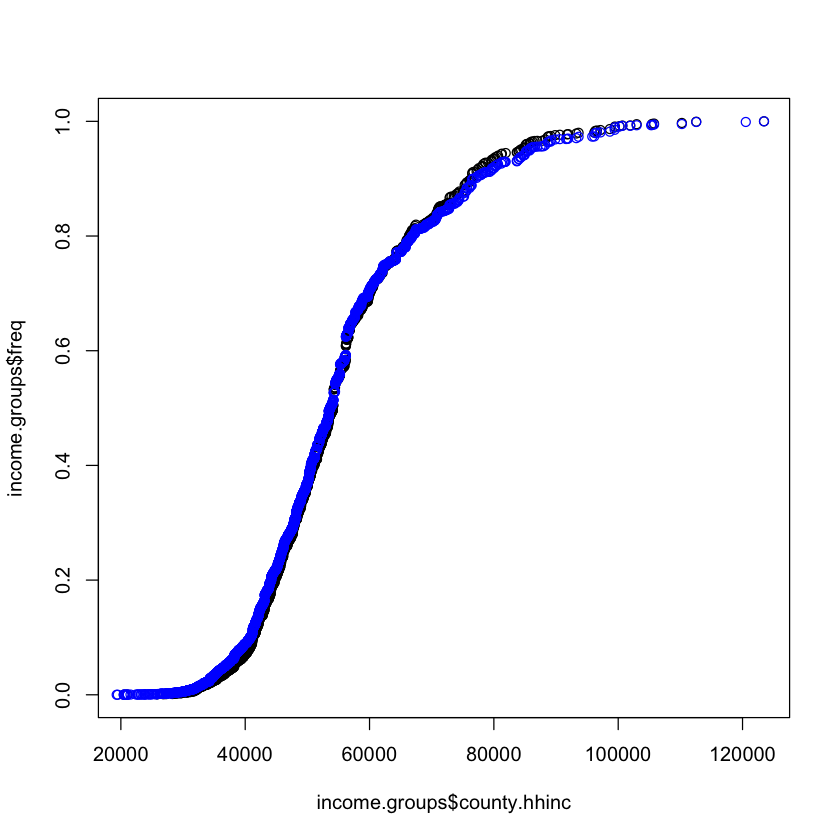

In [75]:
plot(income.groups$county.hhinc, income.groups$freq) 
points(income$county.hhinc, income$freq, col = 'blue') 